# <span style="color:black; font-weight:bold;">Xenium Human Gastric Cancer data Tutorial</span>
#### • <span style="color:black; font-weight:bold;">Creator</span>: Bingjie Dai (17516970902@163.com)
#### • <span style="color:black; font-weight:bold;">Date of Creation</span>: 10.12.2025
#### • <span style="color:black; font-weight:bold;">Date of Last Modification</span>: 10.12.2025
#### • <span style="color:black; font-weight:bold;">Download</span>: Xenium Human Gastric Cancer data used in the tutorial is available at [Gastric.h5ad](https://drive.google.com/file/d/17Dcq1gPQP2qXgA2SfbivhssOK4XQonSl/view?usp=drive_link)
In this tutorial we apply SpaLP to Xenium Human Gastric Cancer data from [Zenodo](https://zenodo.org/records/15164980)

<span style="color:black; font-weight:bold;">The dataset have:</span>   
• <span style="color:black; font-weight:bold;">Xenium Human Gastric Cancer</span>: 696,314 cells and 377 genes  

In [2]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.RandLA import SpatialAutoencoder
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
set_seed(7)

In [6]:
adata=sc.read_h5ad('/home/dbj/SpaLA/Gastric_cancer/Gastric.h5ad')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 696314 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

## <span style="color:black; font-weight:bold;">Data preprocessing</span>
We use [scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) package to perform standard data processing.  
The standard processed expression matrix was saved in adata.obsm[<span style="color:red;">'feat'</span>] and used as input to the model

In [7]:
sc.pp.filter_cells(adata,min_genes=2)
sc.pp.normalize_total(adata,inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat']=adata.X

## <span style="color:black; font-weight:bold;">Compute Spatial Neighbor Graph and build the neighbor index matrix</span>
We compute the spatial Graph using 5 neighbors in simulated data. k=5

In [8]:
k=5
graph = prepare_inputs(adata, k, device)

## <span style="color:black; font-weight:bold;">Define Parameters</span>
The hidden layer dimension is 64, the Adam optimizer is used to optimize the model, the learning rate lr is 0.001, and the model is trained for 200 epochs.

In [9]:
in_channels = graph.features.shape[1]
model = SpatialAutoencoder(in_channels, out_channels=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.47it/s, Epoch=199, Loss=0.9581]


## <span style="color:black; font-weight:bold;">Generate cell embedding and reconstructed gene expression</span>
Cell embedding was saved in adata.obsm[<span style="color:red;">'SpaLP'</span>]. Reconstructed gene expression is constructed as adata2

In [11]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

### Cell embedding

In [12]:
adata.obsm['SpaLP']=embedding

### Reconstructed gene expression

In [13]:
adata2=sc.AnnData(reconstructed)
adata2.obs=adata.obs
adata2.var=adata.var
adata2.uns=adata.uns
adata2.obsm=adata.obsm

In [14]:
adata.write_h5ad('/home/dbj/SpaLP/Gastric/SpaLP.h5ad')
adata2.write_h5ad('/home/dbj/SpaLP/Gastric/Reconstruction.h5ad')

## <span style="color:black; font-weight:bold;">Identify Niches</span>
We compute Leiden clustering based on the SpaLP embeddings to identify spatial niches.  
Here we recommend using the [rapids_singlecell](https://rapids-singlecell.readthedocs.io/en/latest/) package for Ultra large-scale data, a GPU-version of scanpy

In [1]:
import scanpy as sc
import cupy as cp
import time
import rapids_singlecell as rsc
import warnings
warnings.filterwarnings("ignore")

/home/dbj/anaconda3/envs/rapids_singlecell/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=1,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [3]:
data_load_start = time.time()

## <span style="color:black; font-weight:bold;">Load the embedding and add it to GPU</span>

In [4]:
adata=sc.read_h5ad('/home/dbj/SpaLP/Gastric/SpaLP.h5ad')
adata

AnnData object with n_obs × n_vars = 662434 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'log1p', 'spatialdata_attrs'
    obsm: 'SpaLP', 'feat', 'spatial'

In [5]:
rsc.get.anndata_to_GPU(adata)

We compute Leiden clustering based on the SpaLP embeddings to identify spatial niches.  

In [8]:
rsc.pp.neighbors(adata,use_rep='SpaLP')
rsc.tl.leiden(adata, resolution=0.5,key_added='SpaLP',random_state=2024)

## <span style="color:black; font-weight:bold;">Niche identified by SpaLP</span>

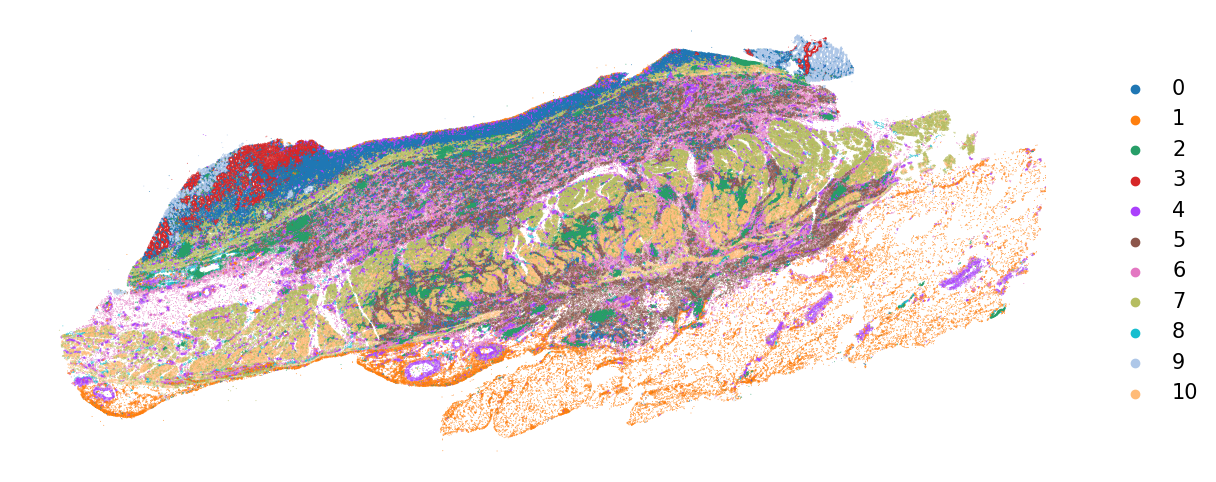

In [11]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata,basis='spatial',color='SpaLP',size=1.5,frameon=False,title='',colorbar_loc=None)

### <span style="color:black; font-weight:bold;">Highlight visualization Niche 3</span>

... storing 'SpaLP_highlight' as categorical


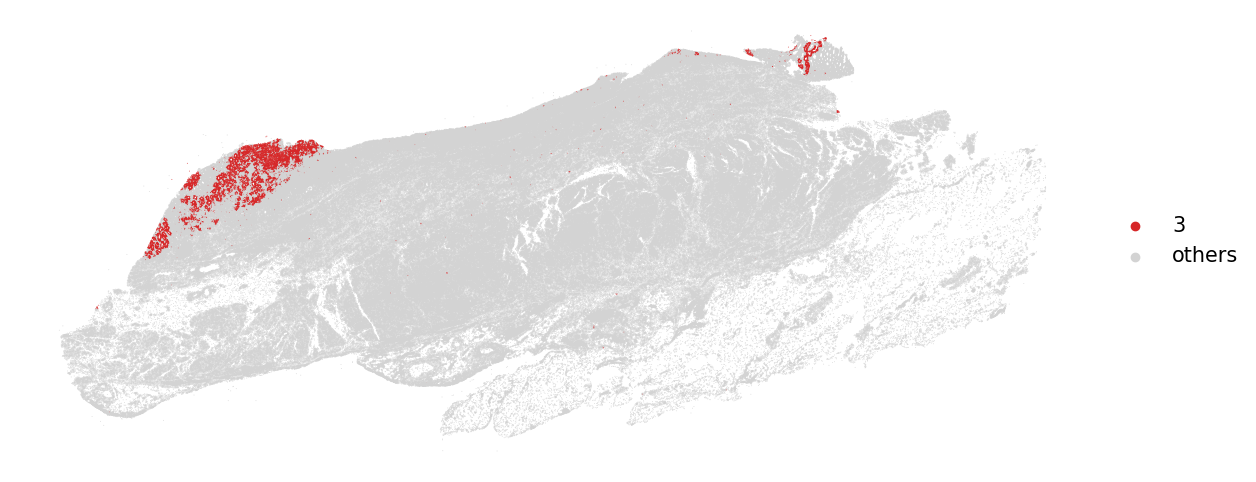

In [15]:
import matplotlib.pyplot as plt
import copy
import numpy as np
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 15

orig_colors = adata.uns['SpaLP_colors']
highlight_color = orig_colors[3] 
custom_colors = ['lightgrey'] * len(orig_colors)
custom_colors[5] = highlight_color
adata.obs['SpaLP_highlight'] = adata.obs['SpaLP'].astype(str)
adata.obs['SpaLP_highlight'] = np.where(adata.obs['SpaLP'] == '3', '3', 'others')

sc.pl.embedding(adata,basis='spatial',color='SpaLP_highlight',palette={'3': highlight_color, 'others': 'lightgrey'},s=1.5,frameon=False,title='')

### <span style="color:black; font-weight:bold;">Highlight visualization Niche 9</span>

... storing 'SpaLP_highlight' as categorical


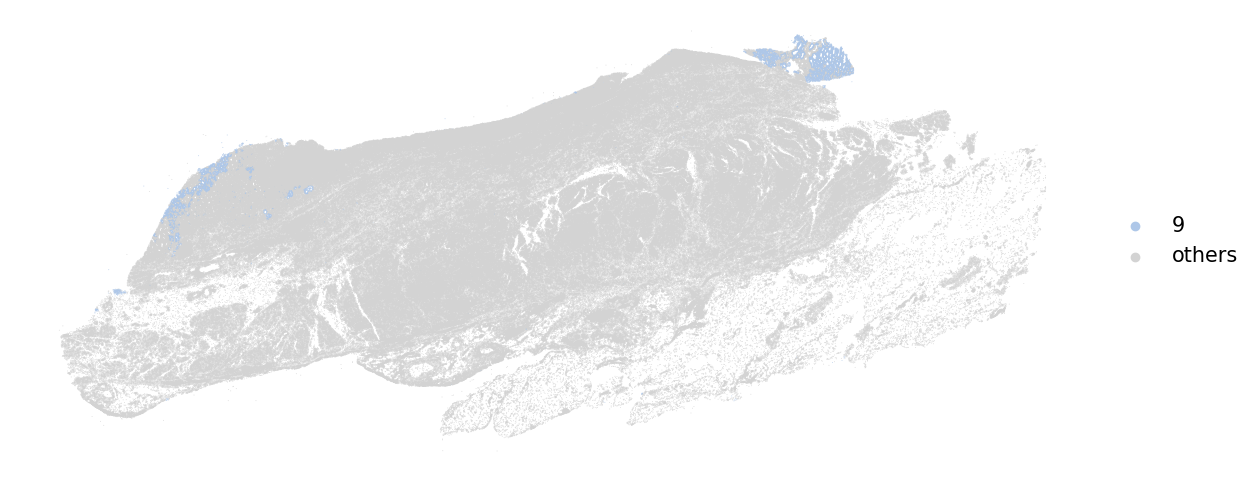

In [17]:
import matplotlib.pyplot as plt
import copy
import numpy as np
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 15

orig_colors = adata.uns['SpaLP_colors']
highlight_color = orig_colors[9] 
custom_colors = ['lightgrey'] * len(orig_colors)
custom_colors[5] = highlight_color
adata.obs['SpaLP_highlight'] = adata.obs['SpaLP'].astype(str)
adata.obs['SpaLP_highlight'] = np.where(adata.obs['SpaLP'] == '9', '9', 'others')

sc.pl.embedding(adata,basis='spatial',color='SpaLP_highlight',palette={'9': highlight_color, 'others': 'lightgrey'},s=1.5,frameon=False,title='')

### <span style="color:black; font-weight:bold;">Highlight visualization Niche 2</span>

... storing 'SpaLP_highlight' as categorical


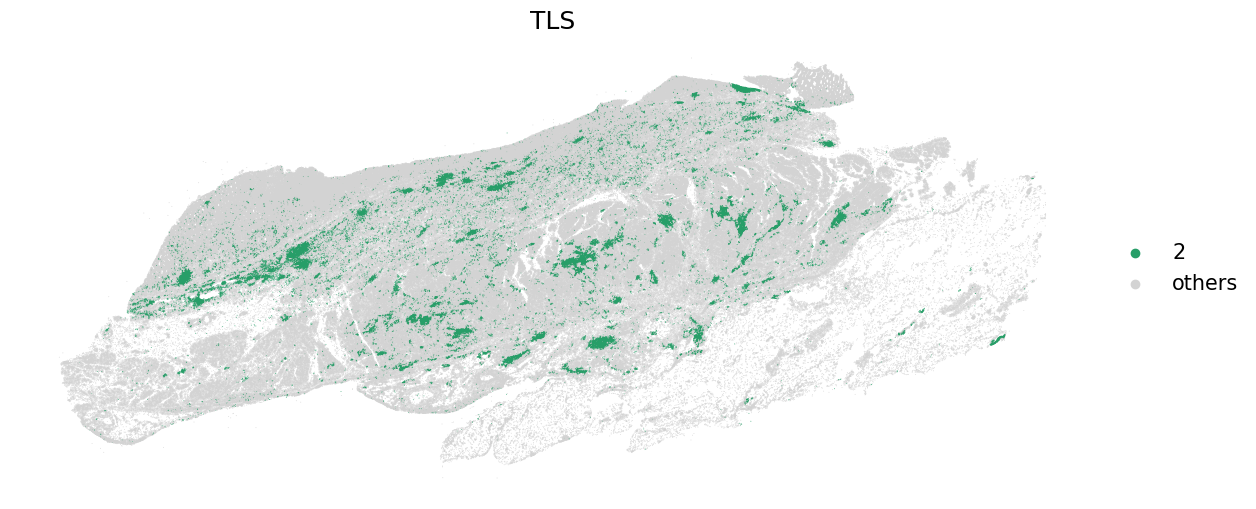

In [18]:
import matplotlib.pyplot as plt
import copy
import numpy as np
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 15

orig_colors = adata.uns['SpaLP_colors']
highlight_color = orig_colors[2] 
custom_colors = ['lightgrey'] * len(orig_colors)
custom_colors[5] = highlight_color
adata.obs['SpaLP_highlight'] = adata.obs['SpaLP'].astype(str)
adata.obs['SpaLP_highlight'] = np.where(adata.obs['SpaLP'] == '2', '2', 'others')

sc.pl.embedding(adata,basis='spatial',color='SpaLP_highlight',palette={'2': highlight_color, 'others': 'lightgrey'},s=1.5,frameon=False,title='TLS')

### <span style="color:black; font-weight:bold;">Highlight visualization Niche 7</span>

... storing 'SpaLP_highlight' as categorical


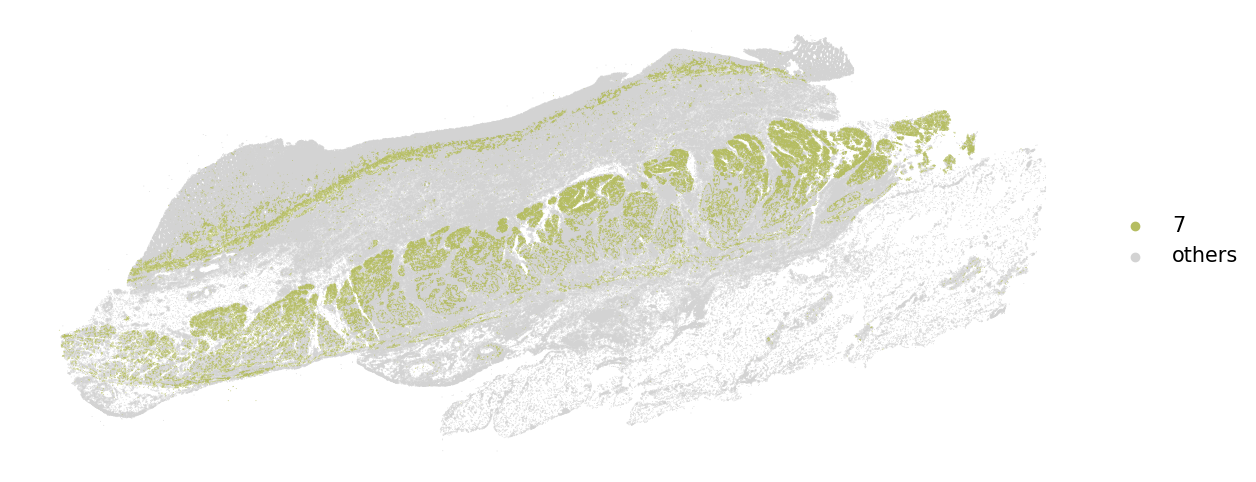

In [19]:
import matplotlib.pyplot as plt
import copy
import numpy as np
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 15

orig_colors = adata.uns['SpaLP_colors']
highlight_color = orig_colors[7] 
custom_colors = ['lightgrey'] * len(orig_colors)
custom_colors[5] = highlight_color
adata.obs['SpaLP_highlight'] = adata.obs['SpaLP'].astype(str)
adata.obs['SpaLP_highlight'] = np.where(adata.obs['SpaLP'] == '7', '7', 'others')

sc.pl.embedding(adata,basis='spatial',color='SpaLP_highlight',palette={'7': highlight_color, 'others': 'lightgrey'},s=1.5,frameon=False,title='')

In [8]:
rsc.get.anndata_to_CPU(adata)

### <span style="color:black; font-weight:bold;">Spatial mapping of CLCA1 gene expression</span>

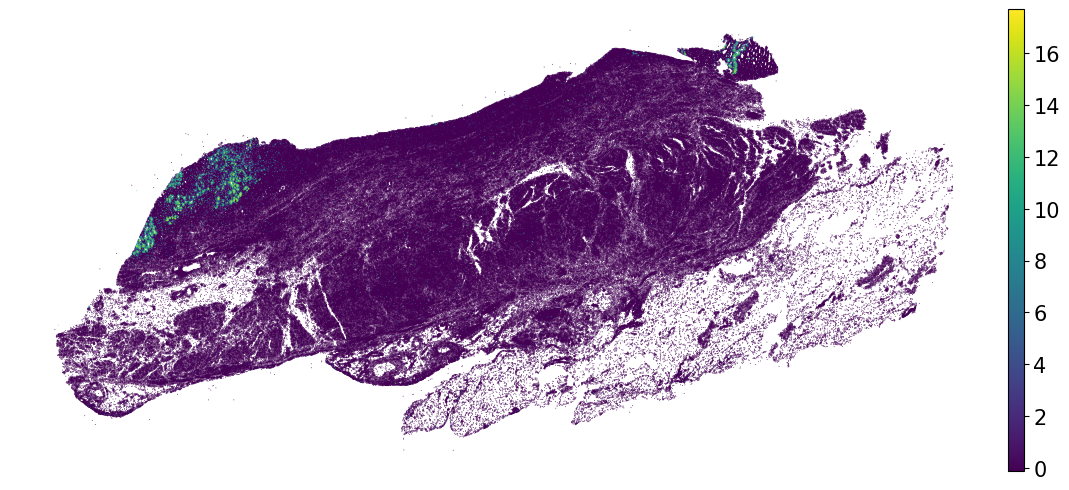

In [9]:
import matplotlib.pyplot as plt
import copy
import numpy as np
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color='CLCA1',s=1.5,frameon=False,title='')

### <span style="color:black; font-weight:bold;">Spatial mapping of TFF2 gene expression</span>

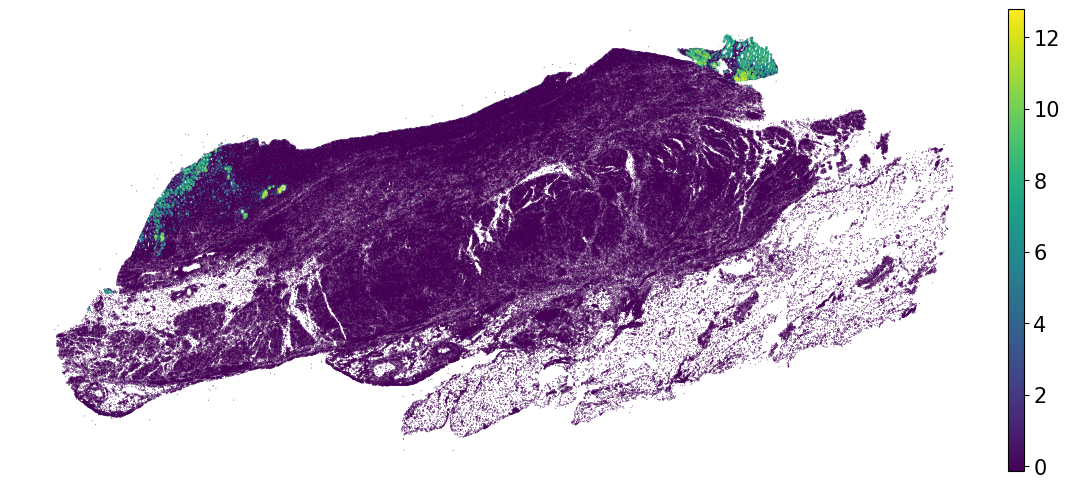

In [10]:
import matplotlib.pyplot as plt
import copy
import numpy as np
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color='TFF2',s=1.5,frameon=False,title='')

### <span style="color:black; font-weight:bold;">Spatial mapping of PTPRC gene expression</span>

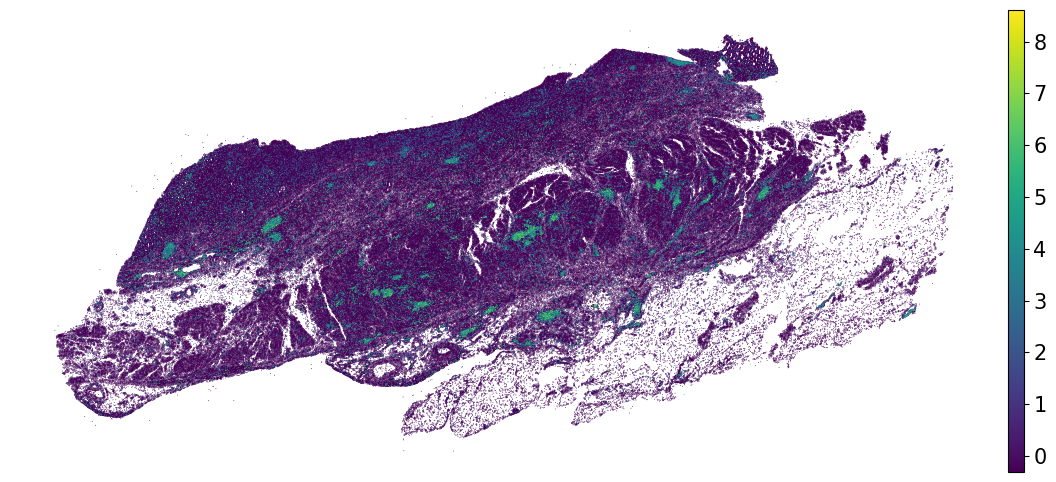

In [13]:
import matplotlib.pyplot as plt
import copy
import numpy as np
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color='PTPRC',s=1.5,frameon=False,title='')

### <span style="color:black; font-weight:bold;">Spatial mapping of MYH11 gene expression</span>

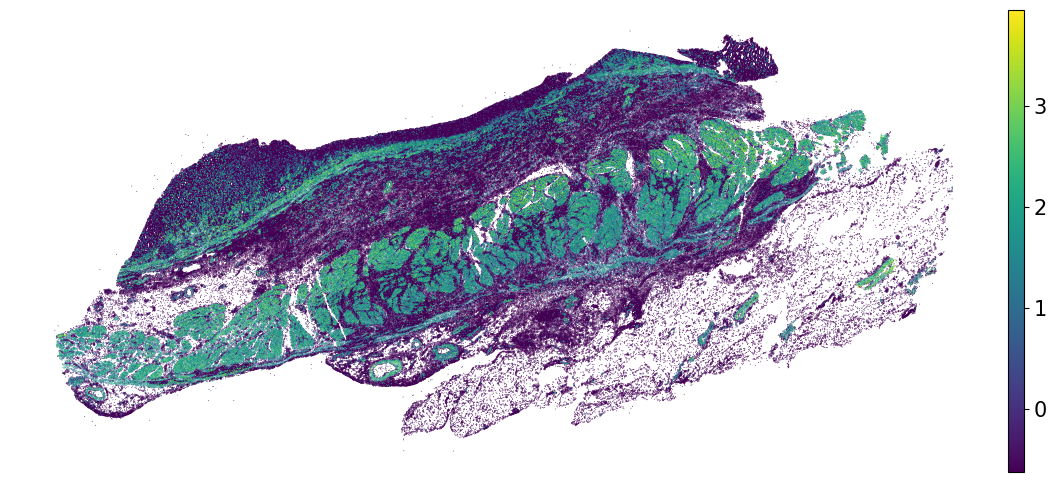

In [12]:
import matplotlib.pyplot as plt
import copy
import numpy as np
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color='MYH11',s=1.5,frameon=False,title='')